# Sarcasm detection in text using transformers.

### Import Libraries:

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\aksha\anaconda3\envs\env311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and Explore the Dataset:

In [3]:
# Load the iSarcasmEval dataset
cwd = os.getcwd()
df=pd.read_csv(cwd+"/iSarcasmEval.csv")

# Explore the dataset
df.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# # Handle missing values if any
df = df.dropna()

### Data Preprocessing:

In [6]:
# Tokenize the 'tweet' column using BERT tokenizer, handling missing values
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_text(text):
    # Check if the text is not NaN
    if not pd.isna(text):
        return tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='tf'
        )
    else:
        # Return a placeholder if the text is missing
        return {'input_ids': [0], 'attention_mask': [0]}

# Apply tokenization to the 'tweet' column, handling missing values
encoded_data = df['tweet'].apply(encode_text)

# Combine input_ids and attention_mask into a single tensor
X = tf.concat([tf.convert_to_tensor(encoded_data.apply(lambda x: x['input_ids'][0]).tolist()),
               tf.convert_to_tensor(encoded_data.apply(lambda x: x['attention_mask'][0]).tolist())], axis=1)

# Target variable
y = np.array(df['sarcastic'].values, dtype=np.int32)

X.shape, y.shape

(TensorShape([867, 256]), (867,))

### Train-Validation Split:

In [7]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X.numpy(),  # Convert TensorFlow tensor to NumPy array
    y,
    test_size=0.2,
    random_state=42
)

# Ensure the data types are appropriate for TensorFlow
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

X_train.shape,y_train.shape,X_val.shape,y_val.shape

(TensorShape([693, 256]),
 TensorShape([693]),
 TensorShape([174, 256]),
 TensorShape([174]))

### Model Fine-Tuning:

In [8]:
# Load pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

# Compile the model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

batch_size = 16  # or any smaller value that works for your system
history = bert_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=batch_size
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
44/44 [==============================] - 990s 22s/step - loss: 0.0625 - accuracy: 0.9957 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 2/3
44/44 [==============================] - 588s 13s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/3
44/44 [==============================] - 488s 11s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000


### Analysis and Visualization:

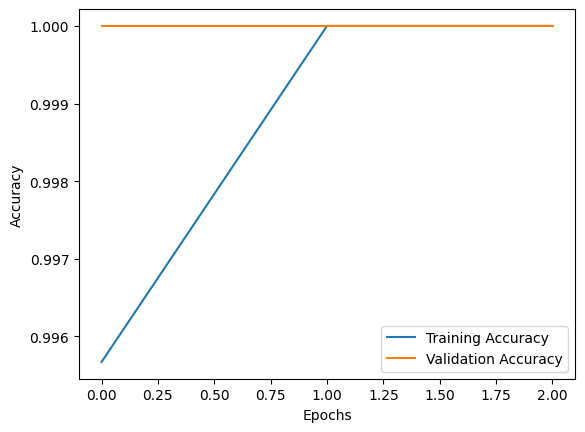

In [9]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Save the Model:

In [10]:
# # Save the trained BERT model
# bert_model.save("bert_sarcasm_model")

# # Save the BERT tokenizer separately
# tokenizer.save_pretrained("bert_sarcasm_tokenizer")

In [11]:
# Save the trained BERT model and tokenizer using the transformers library
bert_model.save_pretrained("bert_sarcasm_model")
tokenizer.save_pretrained("bert_sarcasm_tokenizer")

('bert_sarcasm_tokenizer\\tokenizer_config.json',
 'bert_sarcasm_tokenizer\\special_tokens_map.json',
 'bert_sarcasm_tokenizer\\vocab.txt',
 'bert_sarcasm_tokenizer\\added_tokens.json')